In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import xgboost as xgb
from sklearn.metrics import mean_squared_error
color_pal = sns.color_palette()
plt.style.use('fivethirtyeight')

In [2]:
priceData = pd.read_csv("./data/processed/pricesList.csv")
rainfallData = pd.read_csv("./data/processed/rainfallData.csv")

In [3]:
# extract only one vegetable for the prediction
priceData = priceData[priceData["Name"] == "Potatoes_Local_POTATOES_1Kg"]

In [4]:
def featureEngineering(data):
    data2 = data.copy()
    # iterate through the rainfallData and add the rainfall to the priceData
    for index, row in rainfallData.iterrows():
        # match the year and month from the rainfall data to the pricedata
        year = row['year']
        month = row['month']
        data2.loc[(data2['Year'] == year) & (data2['Month'] == month), 'anuradhapura'] = row['anuradhapura']
        data2.loc[(data2['Year'] == year) & (data2['Month'] == month), 'jaffna'] = row['jaffna']
        data2.loc[(data2['Year'] == year) & (data2['Month'] == month), 'nuwaraeliya'] = row['nuwaraeliya']

    return data2
    

In [5]:
def extractDate(data):
    data2 = data.copy()
    data2["Datetime"] = pd.to_datetime(data2[['Year', 'Month']].assign(day=(data2["Week"]-1)*7 +1))
    data2 = data2.set_index('Datetime')
    return data2

In [6]:
def preprocessData(data):
    data2 = data.copy()
    data2 = data2.dropna()
    return data2

In [7]:
# Removing outliers
from scipy.stats import gaussian_kde
def remove_outliers_kde(df, column_name, threshold=0.05):
    # Extract the values of the column
    column_values = df[column_name].values
    
    # Fit the kernel density estimation
    kde = gaussian_kde(column_values)
    
    # Evaluate the KDE for each data point
    density = kde.evaluate(column_values)
    
    # Sort the data points by their density values
    sorted_indices = np.argsort(density)
    
    # Calculate the threshold index based on the given threshold
    threshold_index = int(len(sorted_indices) * threshold)
    
    # Get the indices of non-outliers
    non_outlier_indices = sorted_indices[threshold_index:]
    
    # Filter out the non-outliers
    df_cleaned = df.iloc[non_outlier_indices]
    df_cleaned = df_cleaned.reset_index(drop=True)
    return df_cleaned

In [8]:
df = featureEngineering(priceData);
df = preprocessData(df);
# df = remove_outliers_kde(df, 'Price')
df = extractDate(df)

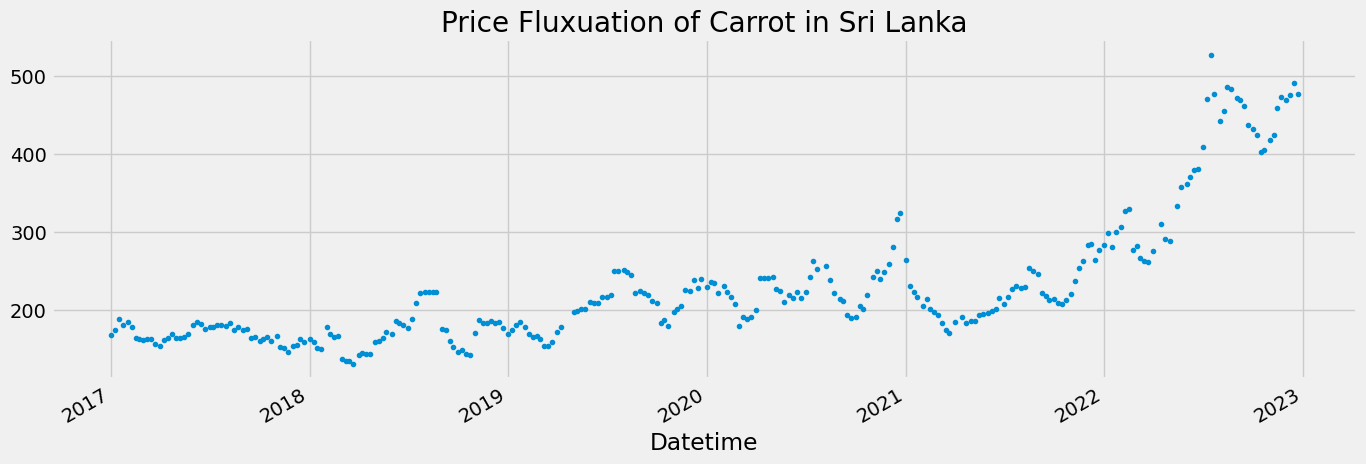

In [9]:
df["Price"].plot(style='.',figsize=(15, 5), title="Price Fluxuation of Carrot in Sri Lanka")
plt.show()

In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 282 entries, 2017-01-01 to 2022-12-22
Data columns (total 9 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Name          282 non-null    object 
 1   Price         282 non-null    float64
 2   Week          282 non-null    int64  
 3   Month         282 non-null    int64  
 4   Year          282 non-null    int64  
 5   Season        282 non-null    object 
 6   anuradhapura  282 non-null    float64
 7   jaffna        282 non-null    float64
 8   nuwaraeliya   282 non-null    float64
dtypes: float64(4), int64(3), object(2)
memory usage: 22.0+ KB


In [11]:
split_date = "2022-08-01"
train = df.loc[df.index < split_date]
test = df.loc[df.index >= split_date]

/tmp/ipykernel_17442/3626683806.py:5: UserWarning: Legend does not support handles for str instances.
A proxy artist may be used instead.
See: https://matplotlib.org/stable/users/explain/axes/legend_guide.html#controlling-the-legend-entries
  ax.legend("Training set", "Test Set")


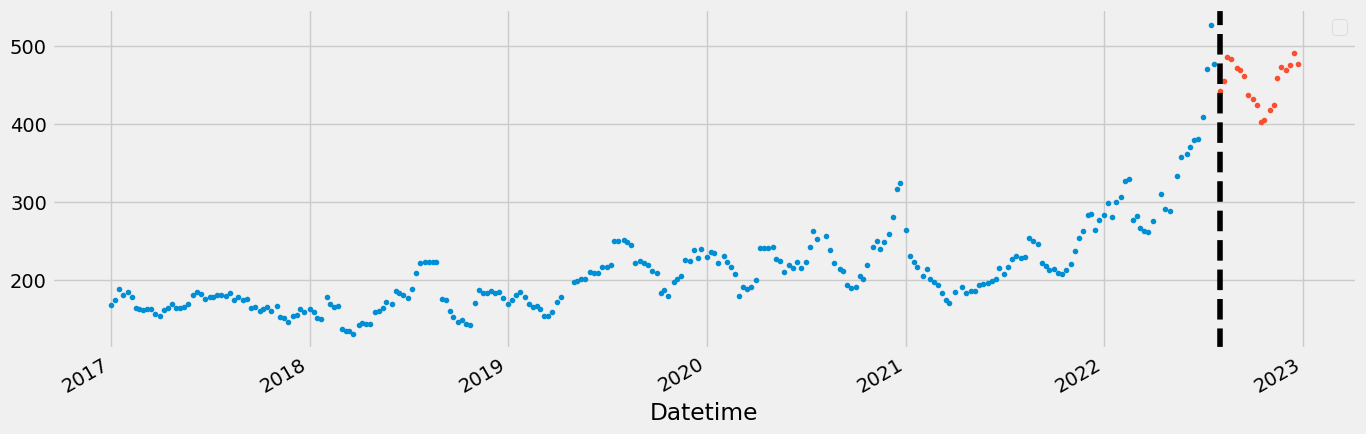

In [12]:
fix, ax = plt.subplots(1, 1, figsize=(15, 5))
train['Price'].plot(ax=ax, label="Train Set", style=".")
test['Price'].plot(ax=ax, label="Test Set", style=".")
ax.axvline(split_date, color="black", ls="--")
ax.legend("Training set", "Test Set")
plt.show()

<Axes: title={'center': 'Price Fluxuation of Carrot in Sri Lanka'}, xlabel='Datetime'>

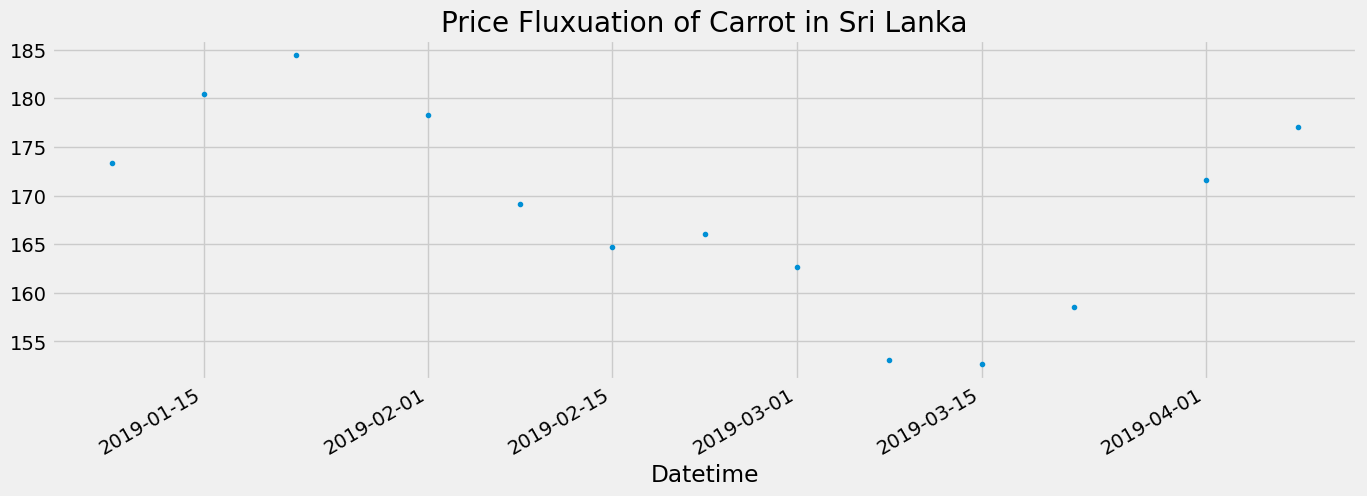

In [13]:
# plot week of data
df["Price"].loc[(df.index > "2019-01-01") & (df.index < "2019-05-01")].plot(style=".", figsize=(15, 5), title="Price Fluxuation of Carrot in Sri Lanka")

In [14]:
df.columns

Index(['Name', 'Price', 'Week', 'Month', 'Year', 'Season', 'anuradhapura',
       'jaffna', 'nuwaraeliya'],
      dtype='object')

In [15]:
FEATURES = ["Week", "Month", "Year", 
            "anuradhapura", 
            "jaffna", 
            "nuwaraeliya"
            ]
TARGET = "Price"

X_train = train[FEATURES]
y_train = train[TARGET]

X_test = test[FEATURES]
y_test = test[TARGET]


In [114]:
# Model Creation
reg = xgb.XGBRegressor(n_estimators=500, learning_rate=0.01)
reg.fit(X_train, y_train, eval_set=[(X_train, y_train), (X_test, y_test)], early_stopping_rounds=350,verbose=50)
# reg.fit(X_test, y_test)

/home/iddhi/.local/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[0]	validation_0-rmse:56.91709	validation_1-rmse:241.55928
[50]	validation_0-rmse:38.24196	validation_1-rmse:163.43440
[100]	validation_0-rmse:26.73186	validation_1-rmse:105.81030
[150]	validation_0-rmse:19.47531	validation_1-rmse:70.79108
[200]	validation_0-rmse:14.64838	validation_1-rmse:50.04253
[250]	validation_0-rmse:11.63153	validation_1-rmse:40.11656
[300]	validation_0-rmse:9.79475	validation_1-rmse:36.95286
[350]	validation_0-rmse:8.62427	validation_1-rmse:36.68824
[400]	validation_0-rmse:7.78488	validation_1-rmse:37.77767
[450]	validation_0-rmse:7.28886	validation_1-rmse:39.34793
[499]	validation_0-rmse:6.96104	validation_1-rmse:40.94554


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.01, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=500, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

In [17]:
from sklearn.ensemble import RandomForestRegressor
reg = RandomForestRegressor(bootstrap=True, criterion='poisson',max_depth=None, max_leaf_nodes=None,n_estimators=10000, random_state=None, n_jobs=1, verbose=0)
reg.fit(X_train, y_train)
# reg.fit(X_test, y_test)

RandomForestRegressor(criterion='poisson', n_estimators=10000, n_jobs=1)

In [117]:
from catboost import CatBoostRegressor

reg = CatBoostRegressor(iterations=70000, depth=5, learning_rate=0.001, loss_function='RMSE')
reg.fit(X_train, y_train, eval_set=(X_test, y_test), verbose=100)
# reg.fit(X_test, y_test)

0:	learn: 57.3627453	test: 243.3043091	best: 243.3043091 (0)	total: 326us	remaining: 22.9s
100:	learn: 54.2580803	test: 235.7039629	best: 235.7039629 (100)	total: 25.5ms	remaining: 17.6s
200:	learn: 51.4151823	test: 228.0731143	best: 228.0731143 (200)	total: 50.4ms	remaining: 17.5s
300:	learn: 48.7451213	test: 220.8088902	best: 220.8088902 (300)	total: 71.9ms	remaining: 16.7s
400:	learn: 46.2790088	test: 214.4691587	best: 214.4691587 (400)	total: 95.1ms	remaining: 16.5s
500:	learn: 43.9864673	test: 208.0719713	best: 208.0719713 (500)	total: 118ms	remaining: 16.4s
600:	learn: 41.8395580	test: 202.2400483	best: 202.2400483 (600)	total: 140ms	remaining: 16.1s
700:	learn: 39.8766721	test: 196.6176221	best: 196.6176221 (699)	total: 163ms	remaining: 16.1s
800:	learn: 38.1253389	test: 191.4960554	best: 191.4960554 (800)	total: 185ms	remaining: 16s
900:	learn: 36.4408804	test: 186.3715938	best: 186.3715938 (900)	total: 211ms	remaining: 16.2s
1000:	learn: 34.8887027	test: 182.2161264	best: 182.

In [139]:
from prophet import Prophet
model = Prophet()
model.fit(train.reset_index().rename(columns={"Datetime": "ds", "Price": "y"}))
forecast = model.predict(test.reset_index().rename(columns={"Datetime": "ds", "Price": "y"}))

15:26:33 - cmdstanpy - INFO - Chain [1] start processing


15:26:33 - cmdstanpy - INFO - Chain [1] done processing


/home/iddhi/.local/lib/python3.10/site-packages/prophet/plot.py:72: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  fcst_t = fcst['ds'].dt.to_pydatetime()
/home/iddhi/.local/lib/python3.10/site-packages/prophet/plot.py:73: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  ax.plot(m.history['ds'].dt.to_pydatetime(), m.history['y'], 'k.',


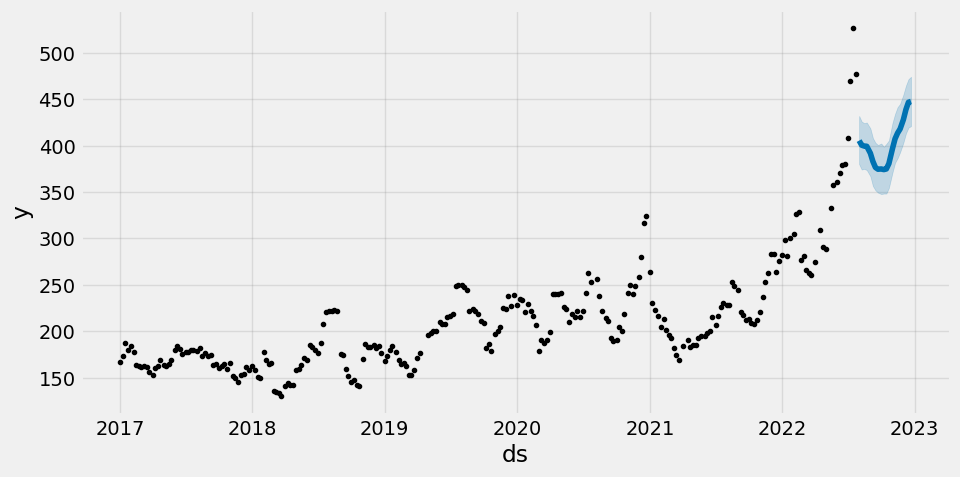

In [140]:
fix, ax = plt.subplots(figsize=(10, 5))
fig = model.plot(forecast, ax=ax)
plt.show()

/home/iddhi/.local/lib/python3.10/site-packages/prophet/plot.py:72: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  fcst_t = fcst['ds'].dt.to_pydatetime()
/home/iddhi/.local/lib/python3.10/site-packages/prophet/plot.py:73: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  ax.plot(m.history['ds'].dt.to_pydatetime(), m.history['y'], 'k.',


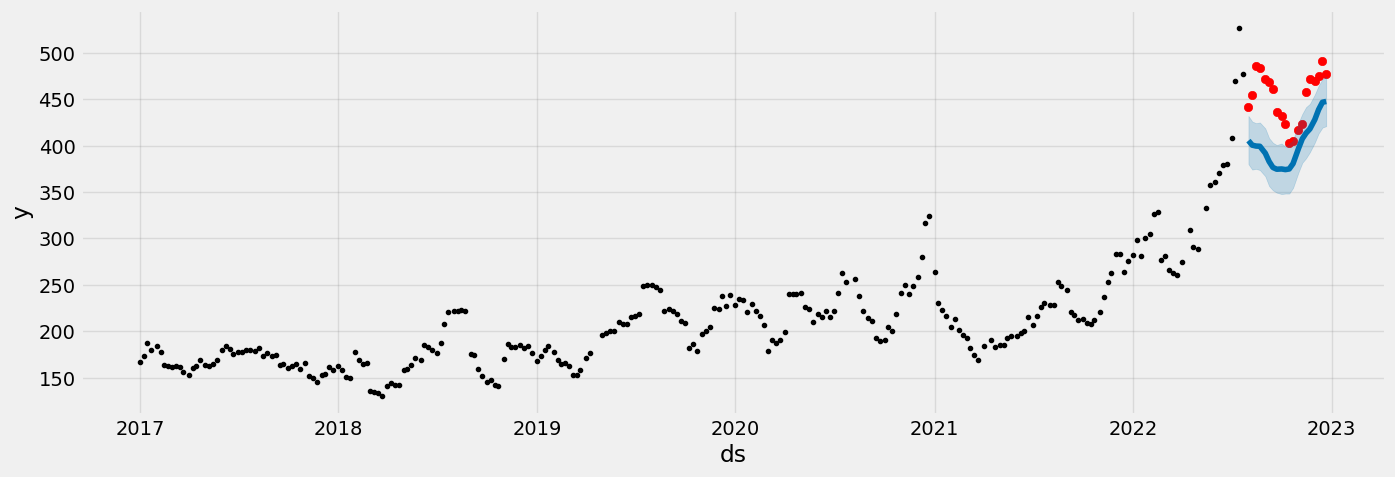

In [141]:
f, ax = plt.subplots(1, 1, figsize=(15, 5))
ax.scatter(test.index, test["Price"], color="r", label="True Price")
fig = model.plot(forecast, ax=ax)
plt.show()


<Axes: xlabel='Datetime'>

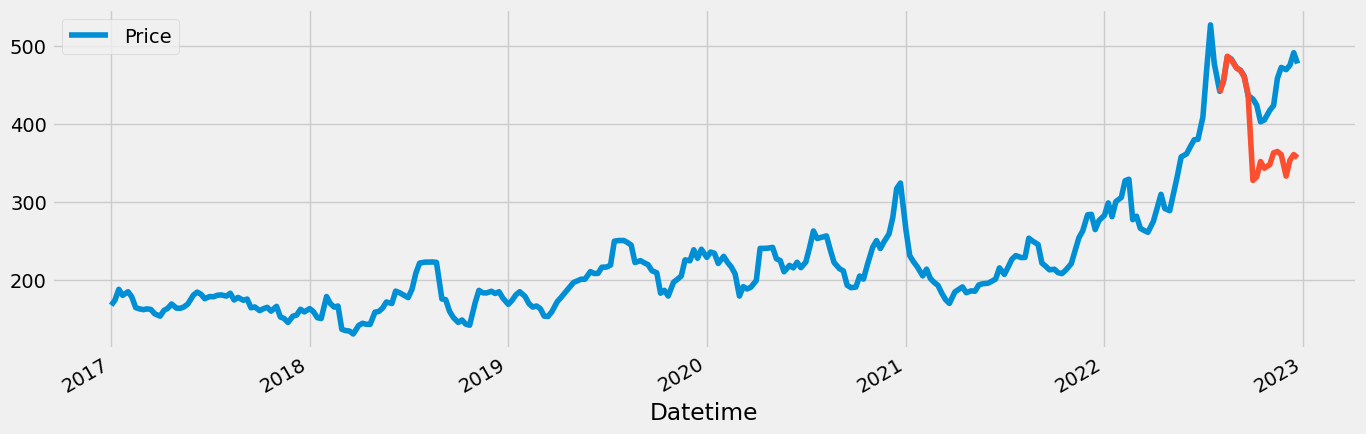

In [148]:
# forecast on test
style = "-"
test2 = test.copy()
test2["prediction"] = reg.predict(X_test)
df2 = df.merge(test2[["prediction"]], how="left", left_index=True, right_index=True)
ax = df2[["Price"]].plot(style=style, figsize=(15,5))
df2["prediction"].plot(style=style, ax=ax)

<Axes: xlabel='Datetime'>

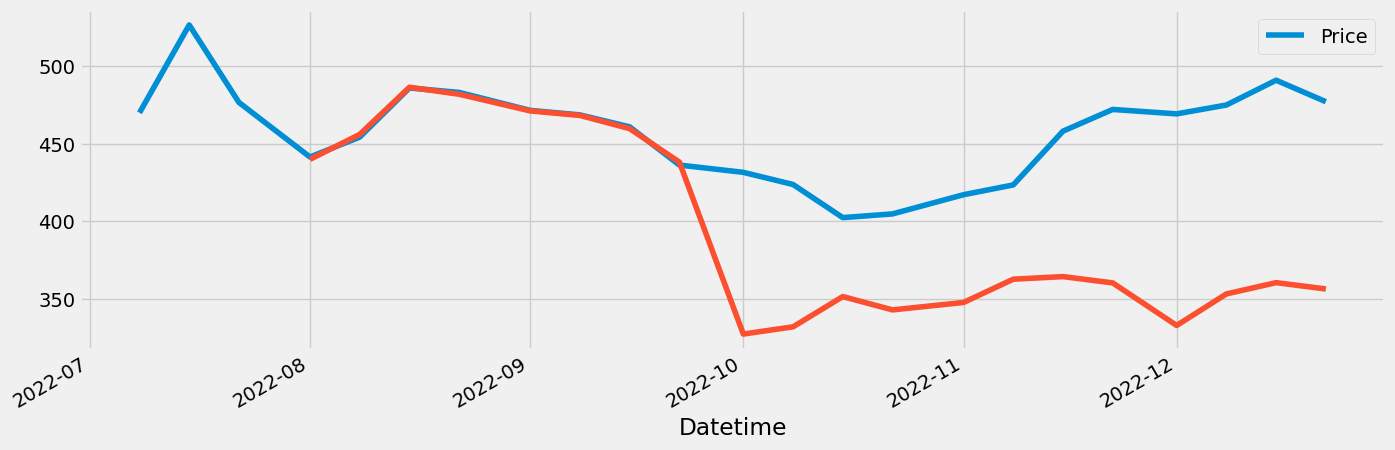

In [149]:
ax = df2.loc[(df2.index > "2022-07-01") & (df2.index < "2025-01-01")][["Price"]].plot(figsize=(15,5), style=style)
df2.loc[(df2.index > "2022-07-01") & (df2.index < "2025-01-01")]["prediction"].plot(ax=ax, style=style)

In [147]:
# model refit
X_train_copy = X_train.copy()
X_train_copy = pd.concat([X_train_copy, X_test.iloc[0:8]])
y_train_copy = y_train.copy()
y_train_copy = pd.concat([y_train_copy, y_test.iloc[0:8]])
reg.fit(X_train_copy, y_train_copy)

0:	learn: 70.9272948	total: 1.35ms	remaining: 1m 34s
1:	learn: 70.8812465	total: 1.84ms	remaining: 1m 4s
2:	learn: 70.8456021	total: 2.1ms	remaining: 49.1s
3:	learn: 70.8102294	total: 2.33ms	remaining: 40.8s
4:	learn: 70.7618427	total: 2.56ms	remaining: 35.9s
5:	learn: 70.7301697	total: 2.81ms	remaining: 32.8s
6:	learn: 70.6900605	total: 3.03ms	remaining: 30.3s
7:	learn: 70.6484499	total: 3.31ms	remaining: 28.9s
8:	learn: 70.5973039	total: 3.56ms	remaining: 27.7s
9:	learn: 70.5447648	total: 3.77ms	remaining: 26.4s
10:	learn: 70.5021588	total: 3.98ms	remaining: 25.3s
11:	learn: 70.4544571	total: 4.24ms	remaining: 24.7s
12:	learn: 70.4139967	total: 4.5ms	remaining: 24.2s
13:	learn: 70.3727449	total: 4.78ms	remaining: 23.9s
14:	learn: 70.3266734	total: 5.03ms	remaining: 23.5s
15:	learn: 70.2805835	total: 5.3ms	remaining: 23.2s
16:	learn: 70.2341783	total: 5.54ms	remaining: 22.8s
17:	learn: 70.1821050	total: 5.86ms	remaining: 22.8s
18:	learn: 70.1378973	total: 6.23ms	remaining: 22.9s
19:	l

# Arima

In [24]:
from pmdarima import auto_arima

In [25]:
df2 = df.copy()
stepwise_fit = auto_arima(df2["Price"], trace=True, suppress_warnings=True)
stepwise_fit.summary()

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=2281.913, Time=0.25 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=2291.842, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=2282.667, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=2281.144, Time=0.04 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=2291.538, Time=0.01 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=2283.065, Time=0.06 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=2283.010, Time=0.09 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=2284.992, Time=0.15 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=2280.308, Time=0.03 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=2282.258, Time=0.04 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=2282.226, Time=0.04 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=2281.782, Time=0.03 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=2284.124, Time=0.09 sec

Best model:  ARIMA(0,1,1)(0,0,0)[0]          
Total fit time: 0.875 seconds


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  282
Model:               SARIMAX(0, 1, 1)   Log Likelihood               -1138.154
Date:                Sun, 03 Mar 2024   AIC                           2280.308
Time:                        14:56:39   BIC                           2287.585
Sample:                             0   HQIC                          2283.227
                                - 282                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1          0.2237      0.042      5.273      0.000       0.141       0.307
sigma2       192.9984      9.702     19.892      0.000     173.983     212.014
===================================================================================
Ljung-Box (L1) (Q):                   0.02   Jarque-Bera (JB):               186.84
Prob(Q):                              0.90   Prob(JB):                         0.00
Heteroskedasticity (H):               3.56   Skew:                            -0.30
Prob(H) (two-sided):                  0.00   Kurtosis:                         6.95
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [26]:
from statsmodels.tsa.arima.model import ARIMA

In [27]:
model = ARIMA(train["Price"], order=(2,1,2))
model = model.fit()
model.summary()

/home/iddhi/.local/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/home/iddhi/.local/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/home/iddhi/.local/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/home/iddhi/.local/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starti

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                  Price   No. Observations:                  262
Model:                 ARIMA(2, 1, 2)   Log Likelihood               -1054.587
Date:                Sun, 03 Mar 2024   AIC                           2119.174
Time:                        14:56:40   BIC                           2136.997
Sample:                             0   HQIC                          2126.338
                                - 262                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.9034      0.334     -2.704      0.007      -1.558      -0.249
ar.L2          0.0934      0.331      0.282      0.778      -0.555       0.742
ma.L1          1.0864      0.372      2.924      0.003       0.358       1.815
ma.L2          0.0910      0.362      0.251      0.802      -0.619       0.801
sigma2       189.2380     12.732     14.863      0.000     164.283     214.193
===================================================================================
Ljung-Box (L1) (Q):                   0.01   Jarque-Bera (JB):               244.65
Prob(Q):                              0.94   Prob(JB):                         0.00
Heteroskedasticity (H):               3.91   Skew:                            -0.33
Prob(H) (two-sided):                  0.00   Kurtosis:                         7.70
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [28]:
start = len(train)
end = len(train) + len(test) - 1
predictions = model.predict(start=start, end=end, typ="levels").rename("ARIMA Predictions")
predictions.index = test.index
print(predictions)

Datetime
2022-08-01    467.001484
2022-08-08    465.685091
2022-08-15    465.971636
2022-08-22    465.589860
2022-09-01    465.961516
2022-09-08    465.590111
2022-09-15    465.960345
2022-09-22    465.591193
2022-10-01    465.959258
2022-10-08    465.592275
2022-10-15    465.958179
2022-10-22    465.593352
2022-11-01    465.957105
2022-11-08    465.594422
2022-11-15    465.956039
2022-11-22    465.595485
2022-12-01    465.954978
2022-12-08    465.596543
2022-12-15    465.953924
2022-12-22    465.597594
Name: ARIMA Predictions, dtype: float64


/home/iddhi/.local/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/home/iddhi/.local/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
/home/iddhi/.local/lib/python3.10/site-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['typ']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


<Axes: xlabel='Datetime'>

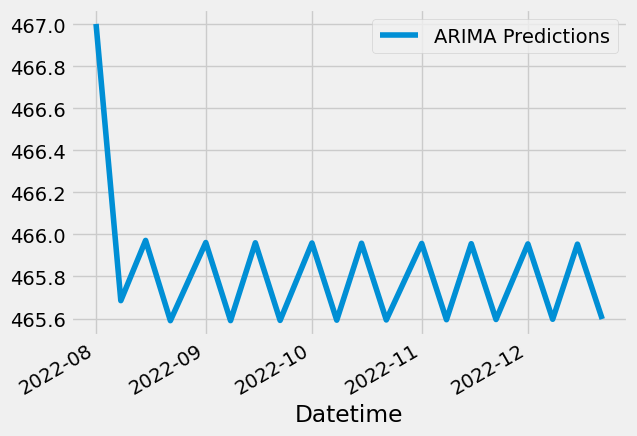

In [29]:
predictions.plot(legend=True)
# test["Price"].plot(legend=True)